In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
# !pip install fpdf

In [3]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import teotil3 as teo
from fpdf import FPDF
from PIL import Image

plt.style.use("ggplot")

# TEOTIL3 Trondheimsfjorden

# Part 8: Explore results for small catchments

## 1. Read model results

In [4]:
nve_data_year = 2024
st_yr, end_yr = 2013, 2023
result_csv = f"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/trondheimsfjorden_results_nve{nve_data_year}_{st_yr}-{end_yr}.csv"

# Areas of interest
reg_dict = {
    "126.4Z": "Hotranvassdraget",
    "125.4A": "Hoplavassdraget",
    "128.C2A": "Lømsen-Langhammerelva",
}

# Scenarios from NIBIO
scen_list = [
    "Baseline",
    "SC1",
    "SC2",
    "SC4",
    "SC5",
    "SC6",
    "SC7a",
    "SC7b",
    "SC8",
    "SC9",
    "AV1",
    "AV2",
    "AV3",
    "AV4",
]

# Pars to compare
# pars = ["totn", "din", "ton", "totp", "tdp", "tpp", "ss", "toc"]
pars = ["totn", "totp", "toc"]

In [5]:
# Read saved data
mod_df = pd.read_csv(result_csv)
mod_df.head()

,scenario,year,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,...,local_urban_totp_kg,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg
0,Baseline,2013,120.111,120.,294.041409,4724.995038,3.341540,7364.350432,75.858338,369.899747,...,29.0,11.6,123.1,6148.3,5.8,56685.2,1047.0,1170.1,33.4,27.6
1,Baseline,2013,120.1120,120.,105.272947,1936.771554,1.311753,2638.932168,29.436172,134.709119,...,1.8,0.7,26.2,1295.5,1.2,11962.9,224.8,251.0,7.1,5.9
2,Baseline,2013,120.112Z,120.,69.306927,91.185524,0.631110,1506.976561,19.288438,88.595366,...,0.0,0.0,60.0,2719.9,2.8,27274.7,511.1,571.1,16.3,13.5
3,Baseline,2013,120.11Z,120.,28.594557,18.969073,1.079797,1769.637270,10.153382,38.747939,...,0.0,0.0,158.4,6800.2,7.5,71711.6,1341.9,1500.3,43.0,35.5
4,Baseline,2013,120.12,120.,112.728112,1903.222957,1.298166,2577.829957,29.549642,142.277754,...,0.0,0.0,88.7,4250.9,4.2,39773.3,758.2,846.9,24.6,20.4


In [6]:
# Filter to vassdragsområder of interest
reg_list = list(reg_dict.keys())
mod_df = mod_df.query("regine in @reg_list")

## 2. Vassdragsområde time series for scenarios

In [7]:
%%capture
for scen in scen_list:
    for reg_id in reg_list:
        scen_df = mod_df.query("scenario == @scen").copy()
        axes = teo.vis.plot_regine_barchart(
            reg_id, scen_df, stat="accum", index_col="year"
        )
        plt.suptitle(
            f"'{scen}' tilførsler",
            fontsize=16,
            fontweight="bold",
        )
        png_fold = f"../results/images/time_series/regine{reg_id}"
        png_path = os.path.join(png_fold, f"regine{reg_id}_{scen.lower()}.png")
        if not os.path.exists(png_fold):
            os.makedirs(png_fold)
        plt.savefig(png_path, dpi=200, bbox_inches="tight")

## 3. Baseline contributions by source

In [8]:
# Get cols of interest
acc_cols = [col for col in mod_df.columns if col.startswith("accum_")]
id_cols = ["scenario", "year", "regine"]
mod_df = mod_df[id_cols + acc_cols]
mod_df.columns = [col.replace("accum_", "") for col in mod_df.columns]

base_df = (
    mod_df.query("scenario == 'Baseline'")
    .groupby("regine")
    .sum(numeric_only=True)
    .reset_index()
)

In [9]:
%%capture
for reg_id in reg_list:
    vassom_df = base_df.query("regine == @reg_id").copy()
    df_list = []
    for par in pars:
        par_cols = [col for col in vassom_df.columns if col.endswith(f"{par}_kg")]
        par_vassom_df = vassom_df[["regine"] + par_cols].copy().set_index("regine")
        par_tot = par_vassom_df.sum(axis="columns").values[0]
        par_vassom_df = (100 * par_vassom_df / par_tot).T.sort_values(
            by=reg_id, ascending=False
        )
        par_vassom_df.index = par_vassom_df.index.str.split("_", n=2, expand=True)
        par_vassom_df.reset_index(inplace=True)
        par_vassom_df.columns = ["Kilde", "Par", "unit", "Prosent"]
        del par_vassom_df["unit"]
        df_list.append(par_vassom_df)
    vassom_df = pd.concat(df_list, axis="rows").query("Prosent > 0")
    vassom_df["Kilde"] = vassom_df["Kilde"].str.capitalize()
    vassom_df["Par"] = vassom_df["Par"].str.upper()
    vassom_df.sort_values("Kilde", inplace=True)

    g = sn.catplot(
        data=vassom_df,
        x="Prosent",
        y="Kilde",
        col="Par",
        col_wrap=3,
        kind="bar",
        col_order=[par.upper() for par in pars],
        height=4,
        aspect=1.3,
    )
    g.fig.suptitle(
        f"Gjennomsnittlige tilførsler etter kilde (2013–2022)",
        y=1.04,
        fontsize=16,
        fontweight="bold",
    )
    for ax in g.axes.flatten():
        for p in ax.patches:
            ax.text(
                p.get_width(),
                p.get_y() + p.get_height() / 2,
                f"{p.get_width():.1f}%",
                ha="left",
                va="center",
            )
    png_path = (
        f"../results/images/baseline_inputs_by_source/regine{reg_id}_source_pct.png"
    )
    plt.savefig(png_path, dpi=200, bbox_inches="tight")

## 4. Reductions compared to the baseline

In [10]:
mod_df = mod_df.melt(id_vars=id_cols).reset_index(drop=True)
mod_df[["source", "par_unit"]] = mod_df["variable"].str.split("_", n=1, expand=True)
del mod_df["variable"]
mod_df = (
    mod_df.groupby(["scenario", "regine", "par_unit"])
    .sum(numeric_only=True)
    .reset_index()
)
del mod_df["year"]

mod_df.head()

,scenario,regine,par_unit,value
0,AV1,125.4A,area_km2,2.225239e+03
1,AV1,125.4A,din_kg,7.856943e+05
2,AV1,125.4A,m3/s,8.050947e+01
3,AV1,125.4A,ss_kg,4.107171e+06
4,AV1,125.4A,tdp_kg,1.355257e+04


In [11]:
df_list = []
for par in pars:
    for reg_id in reg_list:
        par_unit = f"{par}_kg"
        scen_df = mod_df.query("(regine == @reg_id) and (par_unit == @par_unit)").copy()
        baseline_flux = scen_df.loc[scen_df["scenario"] == "Baseline", "value"].values[
            0
        ]
        scen_df["value"] = 100 * (baseline_flux - scen_df["value"]) / baseline_flux
        scen_df = scen_df.query("scenario != 'Baseline'")
        df_list.append(scen_df)
rel_df = pd.concat(df_list, axis="rows")
rel_df["Par"] = rel_df["par_unit"].str.split("_", n=1, expand=True)[0].str.upper()
rel_df["Prosent"] = rel_df["value"]
rel_df["Scenario"] = rel_df["scenario"]
del rel_df["par_unit"], rel_df["value"], rel_df["scenario"]
rel_df.head()

,regine,Par,Prosent,Scenario
17,126.4Z,TOTN,0.000000,AV1
47,126.4Z,TOTN,0.000000,AV2
77,126.4Z,TOTN,0.789976,AV3
107,126.4Z,TOTN,0.789976,AV4
167,126.4Z,TOTN,0.000000,SC1


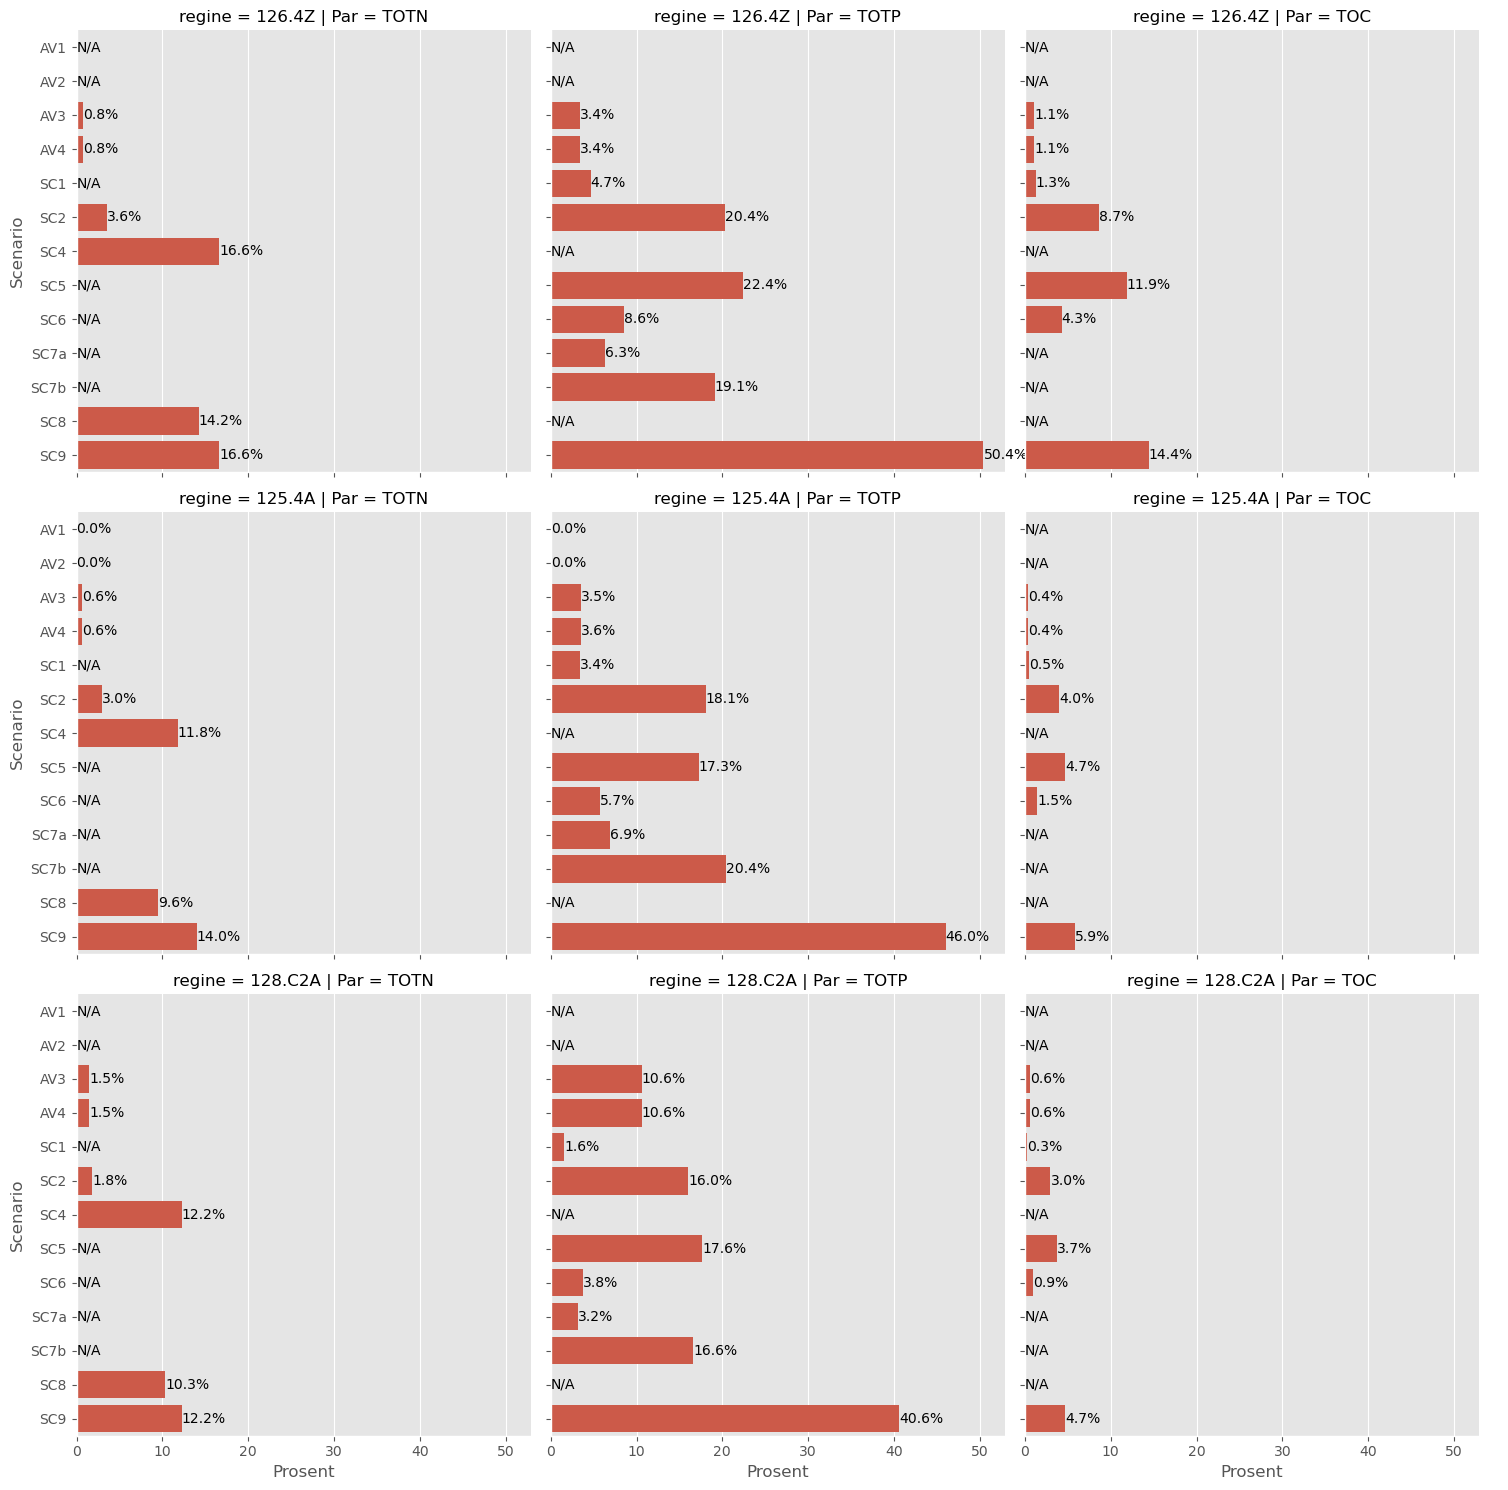

In [12]:
# Single plot for all pars and vassoms
g = sn.catplot(
    data=rel_df, x="Prosent", y="Scenario", row="regine", col="Par", kind="bar"
)
for ax in g.axes.flatten():
    for p in ax.patches:
        if p.get_width() > 0:
            ax.text(
                p.get_width(),
                p.get_y() + p.get_height() / 2,
                f"{p.get_width():.1f}%",
                ha="left",
                va="center",
            )
        else:
            ax.text(
                p.get_width(),
                p.get_y() + p.get_height() / 2,
                "N/A",
                ha="left",
                va="center",
            )
png_path = (
    r"../results/images/pct_reductions/all_regines_scen_reduction_rel_baseline.png"
)
plt.savefig(png_path, dpi=200, bbox_inches="tight")

In [13]:
%%capture
# Separate plots for vassoms
for reg_id in reg_list:
    vassom_rel_df = rel_df.query("regine == @reg_id").copy()
    g = sn.catplot(
        data=vassom_rel_df,
        x="Prosent",
        y="Scenario",
        col="Par",
        col_wrap=3,
        kind="bar",
        col_order=[par.upper() for par in pars],
        height=4,
        aspect=1.3,
    )
    g.fig.suptitle(
        f"Reduksjon i forhold til 'Baseline'",
        y=1.04,
        fontsize=16,
        fontweight="bold",
    )
    for ax in g.axes.flatten():
        for p in ax.patches:
            if p.get_width() > 0:
                ax.text(
                    p.get_width(),
                    p.get_y() + p.get_height() / 2,
                    f"{p.get_width():.1f}%",
                    ha="left",
                    va="center",
                )
            else:
                ax.text(
                    p.get_width(),
                    p.get_y() + p.get_height() / 2,
                    "N/A",
                    ha="left",
                    va="center",
                )
    png_path = f"../results/images/pct_reductions/regine{reg_id}_scen_reduction_rel_baseline.png"
    plt.savefig(png_path, dpi=200, bbox_inches="tight")

## 5. Summary PDF

In [14]:
class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, self.title, 0, 1, "C")

    def footer(self):
        self.set_y(-15)
        self.set_font("Arial", "I", 8)
        self.cell(0, 10, f"Page {self.page_no()}", 0, 0, "C")


def add_image(pdf, image_path, y_position):
    image = Image.open(image_path)
    pdf.image(image_path, x=10, y=y_position, w=190)


def create_pdf(vassom_list):
    pdf = PDF()
    pdf.set_auto_page_break(auto=True, margin=15)

    for vassom in vassom_list:
        print("Processing vassom:", vassom)
        ts_png_path = (
            f"../results/images/time_series/regine{vassom}/regine{vassom}_baseline.png"
        )
        src_png_path = (
            f"../results/images/baseline_inputs_by_source/regine{vassom}_source_pct.png"
        )
        scen_png_path = f"../results/images/pct_reductions/regine{vassom}_scen_reduction_rel_baseline.png"

        pdf.title = f"{reg_dict[vassom]} ({vassom})"
        pdf.add_page()

        add_image(pdf, ts_png_path, 20)
        add_image(pdf, src_png_path, 165)
        add_image(pdf, scen_png_path, 225)

    pdf.output(r"../results/images/regine_summary.pdf")


create_pdf(reg_list)

Processing vassom: 126.4Z
Processing vassom: 125.4A
Processing vassom: 128.C2A
